In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
import torch.nn.functional as TF
from torchlib.transforms import functional as F
from torchlib.datasets.factory  import FactoryDataset
from torchlib.datasets.datasets import Dataset
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset

from torchlib.attentionnet import AttentionNeuralNet
from aug import get_transforms_aug, get_transforms_det


## CONFIGURATE

In [4]:
!ls ../out/

fer_atentionresnet34_attgmm_adam_bu3dfe_dim64_preactresnet18x32_fold01_000


In [7]:
project          = '../out'
name             = 'fer_atentionresnet34_attgmm_adam_bu3dfe_dim64_preactresnet18x32_fold01_000'
pathnamedataset  = '~/.datasets'
pathmodel        = os.path.join( project, name, 'models/model_best.pth.tar' ) #model_best
pathproject      = os.path.join( project, name )
batch_size       = 1
workers          = 1
cuda             = False
parallel         = False
gpu              = 1
seed             = 1
imsize           = 128

## LOAD MODEL

In [8]:
# load model
print('>> Load model ...')

net = AttentionNeuralNet( 
    patchproject=project, 
    nameproject=name, 
    no_cuda=cuda, 
    parallel=parallel, 
    seed=seed, 
    gpu=gpu 
    )

if net.load( pathmodel ) is not True:
    assert(False)

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


>> Load model ...
=> loading checkpoint '../out/fer_atentionresnet34_attgmm_adam_bu3dfe_dim64_preactresnet18x32_fold01_000/models/model_best.pth.tar'
=> loaded checkpoint for atentionresnet34 arch!


## DATASETS

In [9]:
print('>> Load dataset ...')
namedataset = FactoryDataset.bu3dfe
subset = FactoryDataset.validation
imagesize=128

dataset = Dataset(    
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset, 
        subset=subset, 
        download=True 
    ),
    num_channels=3,
    transform=transforms.Compose([
            mtrans.ToResize( (imagesize,imagesize), resize_mode='square' ),
            mtrans.ToTensor(),
            mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
            ])
    )

emotions = dataset.data.classes

if namedataset == FactoryDataset.bu3dfe:
    emotions = emotions[:-1]
print(emotions)


>> Load dataset ...
['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR']


(128, 128, 3)
tensor([[ 0.5461,  0.4256,  0.0222,  0.0007,  0.0009,  0.0008,  0.0038]], device='cuda:1')
tensor(0, device='cuda:1')


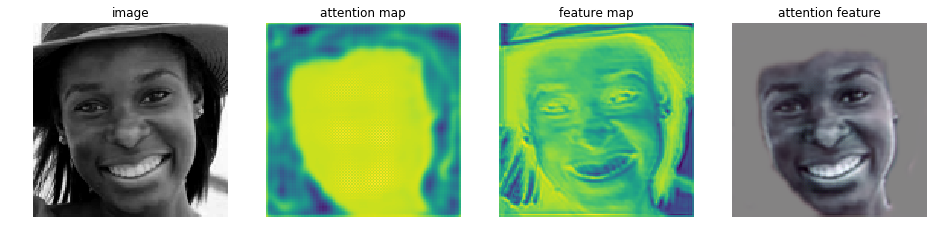

In [25]:
import random

def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)

def pad(image, xypad):
    h,w = image.shape
    im_pad = np.zeros( (h+2*xypad,w+2*xypad) )
    im_pad[xypad:xypad+h,xypad:xypad+w] = image
    return im_pad
    
def crop(image, xycrop):
    h,w = image.shape[:2]
    image = image[ xycrop:h-xycrop,xycrop:w-xycrop ]
    return image 
    
imagesize=128
image = cv2.imread('../rec/selfie001.png')[:,:,0]
# image = pad(image,50)
image = crop(image,75)

# sigma=0.005
# image = image/255.0
# noise = np.array([random.gauss(0,sigma) for i in range( image.shape[0]*image.shape[1]  )])
# noise = noise.reshape(image.shape[0],image.shape[1])
# image = (np.clip(image+noise,0,1)*255).astype(np.uint8)


image = np.stack( (image,image,image), axis=2 )
image = cv2.resize( image, (imagesize, imagesize) )

gamma=1.3
image[:,:,0] = norm((image[:,:,0]/255)**gamma)*255
image[:,:,1] = norm((image[:,:,1]/255)**gamma)*255
image[:,:,2] = norm((image[:,:,2]/255)**gamma)*255

image = torch.from_numpy(image).permute( (2,0,1) ).unsqueeze(0).float()
image = mean_normalization(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

z, y_lab_hat, att, fmap, srf = net( image )


att  = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[:,:,0,0]
srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
y_lab_hat_max = y_lab_hat.argmax()


print(image.shape)
print(y_lab_hat)
print(y_lab_hat_max)

plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow( norm(image) )
plt.title('image')   
plt.axis('off')
plt.subplot(142)
plt.imshow( (fmap))
plt.title('attention map') 
plt.axis('off' )
plt.subplot(143)
plt.imshow( srf.sum(2) )
plt.title('feature map') 
plt.axis('off' )
plt.subplot(144)
plt.imshow( norm(att) )  
# plt.title('class {}'.format( y_lab_hat_max ) ) 
plt.title('attention feature') 
plt.axis('off')

plt.show()

In [103]:
import scipy.misc
import random

def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)

def pad(image, xypad):
    h,w = image.shape
    im_pad = np.zeros( (h+2*xypad,w+2*xypad) )
    im_pad[xypad:xypad+h,xypad:xypad+w] = image
    return im_pad

def crop(image, xycrop):
    h,w = image.shape[:2]
    image = image[ xycrop:h-xycrop,xycrop:w-xycrop , :]
    return image 


def fusion( imx, imy, x=0,y=0, alpha=0.5 ):
    n,m = imy.shape[:2]
    imx[ x:x+n,y:y+m, : ] = alpha*imx[ x:x+n,y:y+m, : ] + (1-alpha)*imy
    return imx

def noise(image, sigma=0.05):
    image = image/255.0
    noise = np.array([random.gauss(0,sigma) for i in range( image.shape[0]*image.shape[1]*3  )])
    noise = noise.reshape(image.shape[0],image.shape[1],3)
    image = (np.clip(image+noise,0,1)*255).astype(np.uint8)
    return image
    
def ligth(image, gamma=0.2):
    image[:,:,0] = norm((image[:,:,0]/255)**gamma)*255
    image[:,:,1] = norm((image[:,:,1]/255)**gamma)*255
    image[:,:,2] = norm((image[:,:,2]/255)**gamma)*255
    return image

class cTrack(object):
    '''track frame
    '''
    
    def __init__(self, net, image_size=128):
        self.imagesize=image_size
        self.net=net
    
    def __call__(self, frame):
        
        #image = frame
        image = frame.mean(axis=2)        
        image = np.stack( (image,image,image), axis=2 )
        
        image = cv2.resize( image, (self.imagesize,self.imagesize) )
        image = torch.from_numpy(image).permute( (2,0,1) ).unsqueeze(0).float()
        image = mean_normalization(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        zhat, y_lab_hat, att, fmap, srf = self.net( image )
        
        att = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
        fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[:,:,0,0]
        srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
        y_lab_hat_max = y_lab_hat.argmax()
        
        return att, fmap, srf, zhat, y_lab_hat, y_lab_hat_max

    
class cFrame(object):
    '''frames porcess
    '''        
    def __init__(self, image_size=[640, 640, 3], border=0, offsetx=0, offsety=0):     
        self.imagesize  = image_size
        self.asp = float(image_size[1])/image_size[0]
        self.border = border
        self.offsetx = offsetx
        self.offsety = offsety 
       
        
    def __call__(self, frame):
        '''process frame 
        '''        
        #H, W original image size
        H=frame.shape[0]; W=frame.shape[1];
        
        #image canonization
        if H>W: frame = frame.transpose(1,0,2)
        H=frame.shape[0]; W=frame.shape[1]     
        
        H1 = int(H - self.border)
        W1 = int(H1 * self.asp)
        offsetx=self.offsetx
        offsety=self.offsety
        Wdif = int(np.abs(W - W1) / 2.0)
        Hdif = int(np.abs(H - H1) / 2.0)
        vbox = np.array([[Wdif, Hdif], [W - Wdif, H - Hdif]])

        frame_p = frame[vbox[0, 1]+offsety:vbox[1, 1]+offsety, vbox[0, 0]+offsetx:vbox[1, 0]+offsetx, : ]; #(2, 1, 0)
        aspY = float(self.imagesize[0]) / frame_p.shape[0]
        aspX = float(self.imagesize[1]) / frame_p.shape[1]

        frame_p = scipy.misc.imresize(frame_p, (self.imagesize[0], self.imagesize[1]), interp='bilinear')
        
        return frame_p
    
    
def drawcaption( y, emotions, imsizeout=(200,200) ):    
    
    ne = len(emotions)
    colors = ([150,150,150],[130,130,130],[255,255,255],[255,255,255])
    hbox=40; wbox= 135 + 170
    
    imsize=(hbox*ne,wbox,3)
    imemotions = np.zeros( imsize, dtype=np.uint8 )*255    
    
    ymax = y.argmax()
    
    for i, yi in enumerate(y):

        k  = 1 if y[i]>0.5 else 0
        kh = 1 if ymax==i else 0
    
        bbox = np.array([[0,0],[wbox,0],[wbox,hbox],[0,hbox]]);    
        bbox[:,0] += 0
        bbox[:,1] += 26-26 + (i)*40
        imemotions = cv2.fillConvexPoly(imemotions, bbox, color=colors[kh] )
        
        bbox = np.array([[0,0],[int(wbox*y[i]),0],[int(y[i]*wbox),hbox],[0,hbox]]);    
        bbox[:,0] += 0
        bbox[:,1] += 26-26 + (i)*40
        imemotions = cv2.fillConvexPoly(imemotions, bbox, color=[255,160,122] )
        
        cv2.putText(
                imemotions, 
                '{}: {:.3f}'.format(emotions[i][:-5],y[i]), 
                (2, 26 + (i)*40), 
                color=colors[2+kh], 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=1, 
                thickness=2
                )
        
    #imemotions = imemotions[20:-20,20:-20,:]
    imemotions = cv2.resize( imemotions, imsizeout )
    return imemotions






In [118]:
import cv2 
from IPython.display import clear_output

filename = '../out/exp_mz_sn.mkv'
cap = cv2.VideoCapture( filename )

print(cap.isOpened())
frame_proc = cFrame( image_size=[128,128,3] ) 
track   = cTrack( net, image_size=128 )

k = 0
iframe=0
iniframe=0



# for every frame
while(cap.isOpened()):
    
    # read
    #for i in range(100): 
    #    ret, frame = cap.read()

    ret, frame = cap.read()
        
    if k%2 != 0 or k < iniframe:
        k+=1
        continue
        
    #print(k)
        
        
    frame = frame[:-300,850:,:]
    image = frame_proc( frame )
    image = crop(image,15)
    
    #noise
    #image = noise(image, sigma=0.05)
    
    #ligth
    #image = ligth(image, gamma=0.5)

    
    att, fmap, srf, zhat, yhat, yhat_max = track( image )
    yhat = TF.softmax( yhat, dim=1 )[0,:]
    att_map = att.mean(axis=2)
    
    #print(yhat)
    
    
    #create video frame   
    imsize=500
    layer   = np.zeros( [768, 1024, 3] , dtype=np.uint8 )*255 
    caption = drawcaption(yhat, emotions )
    image   = cv2.resize( image, (imsize,imsize) )[:,:,(2,1,0)]
    att     = cv2.resize( norm(att)*255, (imsize,imsize) )
    image   = np.concatenate( (image, att), axis=1 )
    
    
    #layer
    
    layer = fusion(layer, image, x=10+100, y=10, alpha=0.0 )
    layer = fusion(layer, caption, x=20+100, y=20, alpha=0.2 )
    
    cv2.imwrite('../out/result/{:06d}.png'.format(iframe), layer[:,:,(2,1,0)] )
    k+=1; iframe+=1
    
    # show
    ishow=False
    if ishow:
        plt.figure( figsize=(16,8) )
        plt.imshow( layer )
        plt.axis('off')
        plt.show()
        clear_output(wait=True) 
    
    if iframe%100 == 0:
        print(k, iframe)        

       
    
    if k > iniframe+1000:
        break

cap.release()
print('DONE!!!')



True
199 100
399 200
599 300
799 400
999 500
DONE!!!
